## GLAM fit. Perceptual. Gamma parameter limited to 0 - 1 . (Marius Usher recommendation)

In [1]:
import glam
import pandas as pd
import numpy as np
import os.path
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

In [4]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

# Individual GLAM estimation and out of sample prediction

## Load data

In [5]:
# Load data
sufix = '_individual_Less_Inv_NoBin_excludedTrial_Gamma_01_NUTS_32'
data = pd.read_csv('data/PF2019_data/GlamDataPF2019_Less_Inv_NoBin_33.csv')

## Reaction times for each participant

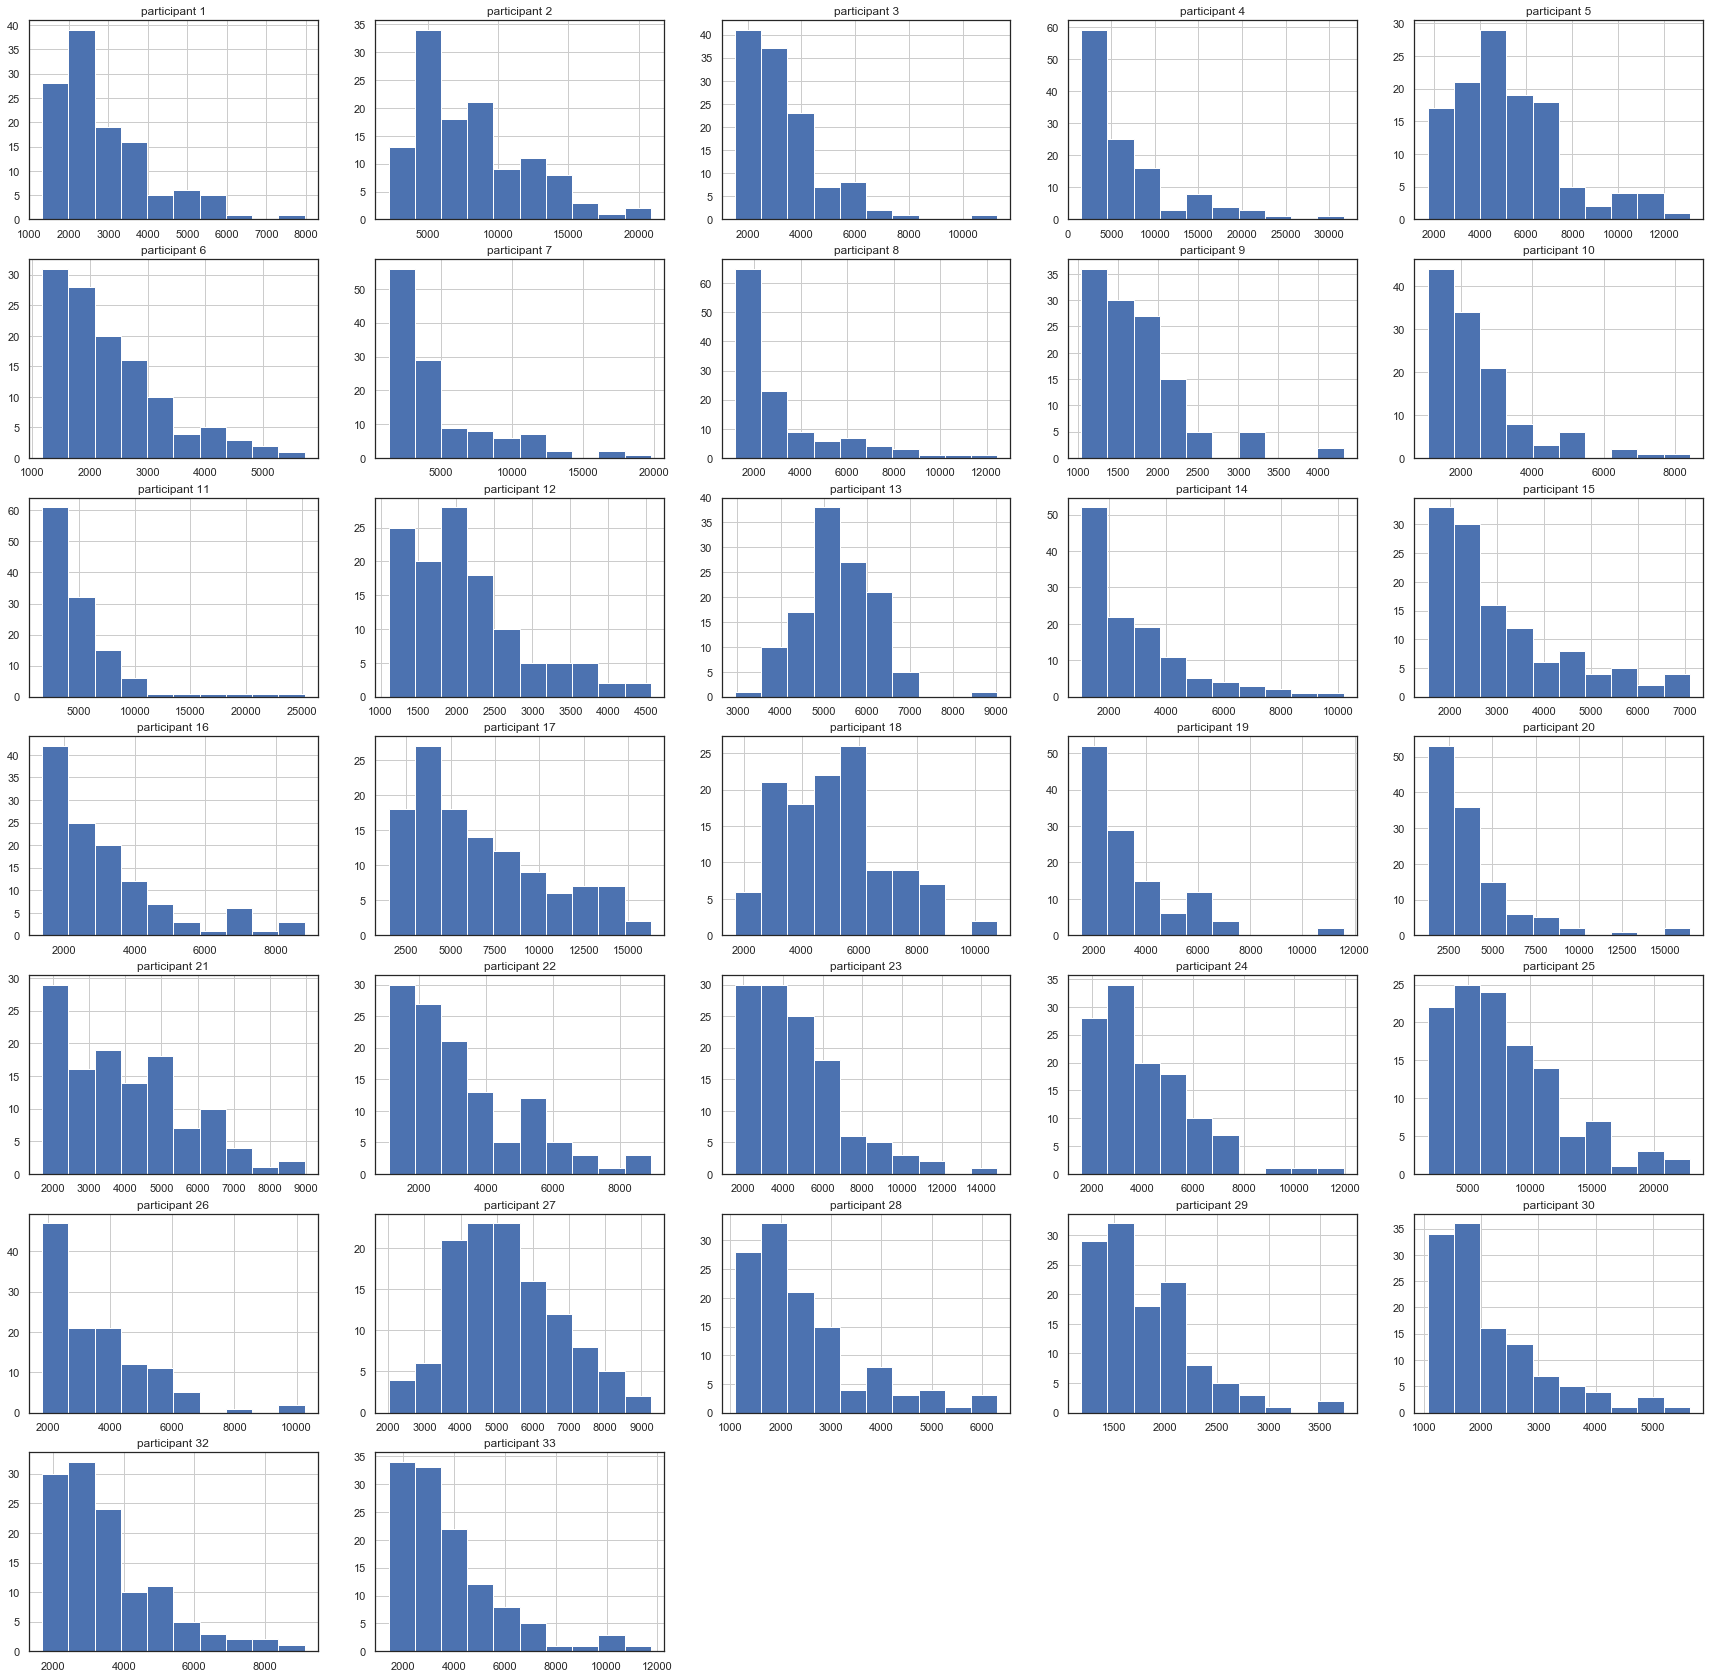

In [6]:
participants = data.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data[(data.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1


In [7]:
data["zrt"] = z_score1(data,'subject',"rt")

## Remove outliers

In [8]:
# remove outliers (two criteria)
data1 = data[(data.zrt <= 3) ]
data1 = data1[(data1.rt <= 20000) ]

In [9]:
#participants = data.subject.unique()
#f = plt.figure(figsize=(30,30))
#order = 1
#sns.set_style('white')

#for i in data.subject.unique():
#    sub={}
#    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
#    sub['%s' % i].plot()    
#    data[(data.subject == i)].zrt.hist()
#    sub['%s' % i].set_title('participant %s' % i)
#    order += 1

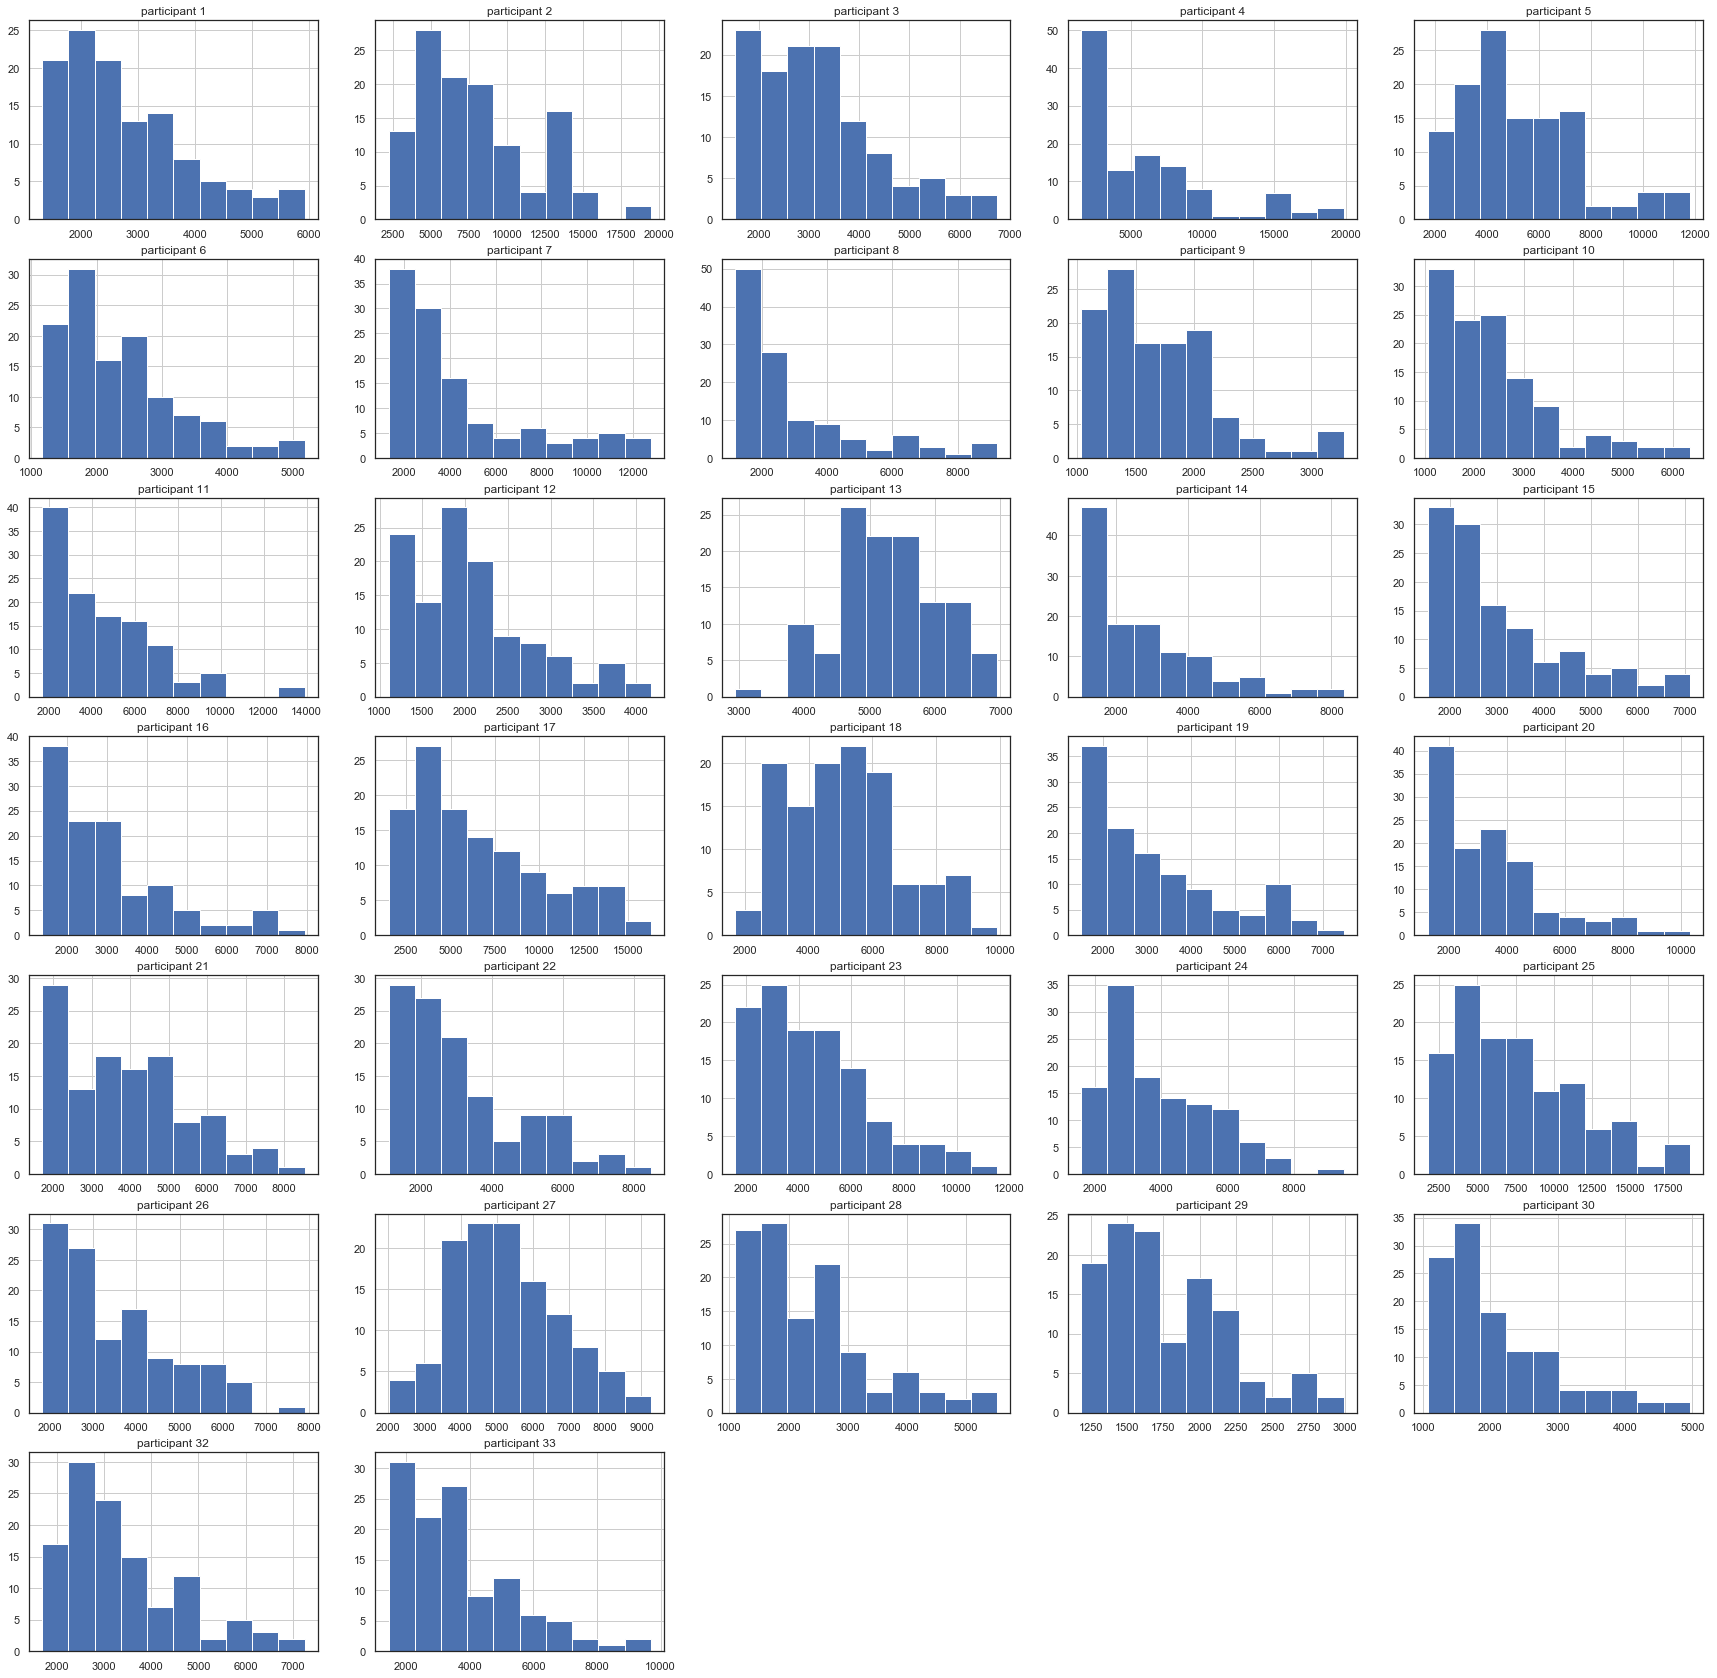

In [10]:
participants = data1.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data1.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data1[(data1.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1

# Subset only necessary columns


In [11]:
# Subset only necessary columns
data = data1[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,1,0,0,4261.735,63,42,0.603448,0.396552
1,1,1,1,3559.258,126,123,0.490772,0.509228
2,1,2,1,3754.464,123,129,0.490893,0.509107
3,1,3,0,2431.751,116,123,0.639125,0.360875
4,1,4,0,2199.342,131,123,0.702232,0.297768


## Split data in training and test sets

In [12]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1895 trials) and test (1883 trials) sets...


## Individual GLAM estimation

### 1. full GLAM

In [13]:
# Fitting full GLAM
print('Fitting full GLAM individually...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_full'+sufix+'.npy')):
    glam_full.make_model('individual', gamma_bounds=(0, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full'+sufix+'.npy'))   

Fitting full GLAM individually...
Generating single subject models for 32 subjects...


INFO (theano.gof.compilelock): Waiting for existing lock by process '61109' (I am process '61112')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/pradyumna/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 32 model(s) using NUTS...
  Fitting model 1 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:23<00:00, 512.90draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9568231613284907, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3731483916559832, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:27<00:00, 431.32draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 3 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 495.17draws/s]
The acceptance probability does not match the target. It is 0.8906624734080614, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 4 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:22<00:00, 527.76draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 5 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:18<00:00, 657.75draws/s]
The acceptance probability does not match the target. It is 0.8950342316233267, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 6 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 483.76draws/s]
The acceptance probability does not match the target. It is 0.6062805834747593, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5530719229528643, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 7 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:23<00:00, 169.71draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 8 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:23<00:00, 518.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 9 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [24:08<00:00,  2.45draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.45694571234963816, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 10 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:19<00:00, 623.32draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 11 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:26<00:00, 453.51draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7093567365822423, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 12 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:20<00:00, 580.27draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 13 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [19:05<00:00,  2.57draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9255869643561818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5428902163042847, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 14 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:19<00:00, 609.08draws/s]
There were 770 divergences after tuning. Increase `target_accept` or reparameterize.
There were 897 divergences after tuning. Increase `target_accept` or reparameterize.
There were 985 divergences after tuning. Increase `target_accept` or reparameterize.
There were 920 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 15 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:20<00:00, 574.07draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 16 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:29<00:00, 410.35draws/s]
The acceptance probability does not match the target. It is 0.6980726260515382, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6989668448418139, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 17 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:36<00:00, 332.67draws/s]
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 18 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:23<00:00, 231.25draws/s]
The acceptance probability does not match the target. It is 0.8812307534627429, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5796792734472807, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4121113756513893, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 19 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:22<00:00, 528.54draws/s]
The acceptance probability does not match the target. It is 0.6642757952314899, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 20 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:26<00:00, 460.11draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 21 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:21<00:00, 550.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 22 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 499.62draws/s]
There were 405 divergences after tuning. Increase `target_accept` or reparameterize.
There were 399 divergences after tuning. Increase `target_accept` or reparameterize.
There were 414 divergences after tuning. Increase `target_accept` or reparameterize.
There were 390 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 23 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:30<00:00, 399.16draws/s]
The acceptance probability does not match the target. It is 0.7199037327241617, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 24 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:26<00:00, 455.69draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 25 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 493.00draws/s]
The acceptance probability does not match the target. It is 0.9242653354416648, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 26 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:30<00:00, 394.98draws/s]
The acceptance probability does not match the target. It is 0.4988654345172787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.49433710214713206, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 27 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:26<00:00, 458.43draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.881203020332573, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 28 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 483.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 29 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [26:45<00:00,  3.30draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8853409997930693, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 30 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 898.45draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 31 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:17<00:00, 688.14draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 32 of 32...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 855.69draws/s]
The acceptance probability does not match the target. It is 0.7109520444909204, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5479037513649542, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/!\ Automatically setting parameter precision...


In [14]:
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_full'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

,SNR,b,gamma,p_error,s,t0,tau,v
0,116.23,1.0,0.71,0.05,0.007489,[0.0],0.06,0.000051
1,412.47,1.0,0.52,0.05,0.005574,[0.0],0.12,0.000015
2,197.78,1.0,0.10,0.05,0.006961,[0.0],0.37,0.000033
3,480.37,1.0,0.53,0.05,0.009161,[0.0],0.15,0.000021
4,161.23,1.0,0.09,0.05,0.005097,[0.0],0.07,0.000031
5,97.36,1.0,0.04,0.05,0.005720,[0.0],0.11,0.000048
6,213.88,1.0,0.20,0.05,0.007897,[0.0],0.12,0.000031
7,108.20,1.0,0.01,0.05,0.006673,[0.0],0.08,0.000054
8,48.72,1.0,0.95,0.05,0.005216,[0.0],0.02,0.000106
9,171.42,1.0,0.28,0.05,0.008550,[0.0],0.15,0.000053


In [15]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_PF2019_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_PF2019_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_PF2019_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...


/Users/pradyumna/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/pymc3/stats.

In [16]:
glam_full.waic

array([[1.02030972e+03, 0.00000000e+00, 3.15075693e+00, 1.00000000e+00],
       [1.19425883e+03, 0.00000000e+00, 2.99218755e+00, 1.00000000e+00],
       [1.01125854e+03, 0.00000000e+00, 2.11174625e+00, 1.00000000e+00],
       [1.18122046e+03, 0.00000000e+00, 3.48205130e+00, 1.00000000e+00],
       [1.11470475e+03, 0.00000000e+00, 2.24498913e+00, 1.00000000e+00],
       [9.82398519e+02, 0.00000000e+00, 6.06157335e+00, 1.00000000e+00],
       [1.10002133e+03, 0.00000000e+00, 4.67688614e+00, 1.00000000e+00],
       [1.01395650e+03, 0.00000000e+00, 3.09196141e+00, 1.00000000e+00],
       [9.36454461e+02, 0.00000000e+00, 1.55085590e+00, 1.00000000e+00],
       [9.78466655e+02, 0.00000000e+00, 3.10030041e+00, 1.00000000e+00],
       [1.08180124e+03, 0.00000000e+00, 1.91717137e+00, 1.00000000e+00],
       [9.73291488e+02, 0.00000000e+00, 2.64755569e+00, 1.00000000e+00],
       [1.23281187e+03, 0.00000000e+00, 1.05657362e+02, 1.00000000e+00],
       [1.05792494e+03, 0.00000000e+00, 1.66651011e

In [17]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_full'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1895 trials) with new data (1883 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,0.0,1.0,3604.0,126,0.490772,123,0.509228
1,1.0,0.0,1.0,0.0,2703.0,126,0.490772,123,0.509228
2,1.0,0.0,2.0,0.0,1604.0,126,0.490772,123,0.509228
3,1.0,0.0,3.0,0.0,4477.0,126,0.490772,123,0.509228
4,1.0,0.0,4.0,0.0,2934.0,126,0.490772,123,0.509228


## 2. Plot fit

In [ ]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
glam.plots_pretty.plot_fit(test_data, [glam_full.prediction]);

#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## [END] 